In [1]:
import torch
import math
import matplotlib.pyplot as plt
torch.set_grad_enabled (False);

# Activation functions

In [2]:
class Tanh():  
    def forward(self, *input):
        self.s=input[0]
        return input[0].tanh()
    
    def backward(self, *gradwrtoutput):
        dl_dx=gradwrtoutput[0]
        dl_ds=(4 * (self.s.exp() + self.s.mul(-1).exp()).pow(-2))*dl_dx
        return dl_ds
    
    def param(self):
        return []  
    def reset(self):
        return []
    def update(self,eta):
        return []
    
class Relu():
    def forward(self, *input):
        self.s=input[0]
        return input[0].relu()
    
    def backward(self, *gradwrtoutput):
        dl_dx=gradwrtoutput[0]
        dl_ds=(self.s>0).float()*dl_dx
        return dl_ds
    
    def param(self):
        return []  
    def reset(self):
        return []
    def update(self,eta):
        return []

class Sigmoid():
    def forward(self, *input):
        self.s=input[0]
        return input[0].sigmoid()
    
    def backward(self, *gradwrtoutput):
        dl_dx=gradwrtoutput[0]
        dl_ds=(self.s.mul(-1).exp()/(1+self.s.mul(-1).exp()).pow(2))*dl_dx
        return dl_ds
    
    def param(self):
        return []  
    def reset(self):
        return []
    def update(self,eta):
        return []    
    

# Layers and criterions

In [3]:
#  input in a tuple of tensor composed of the weights, the bias and the input vector   
# and return a tuple composed of the in put vector and the output vector
class Linear():
       
    def __init__(self,n_in,n_out):      
        self.w = torch.empty(n_out, n_in).normal_()
        self.b =torch.empty(n_out).normal_()
        
        self.dl_dw = torch.empty(self.w.size())
        self.dl_db = torch.empty(self.b.size())
        self.x=torch.empty(n_in)
        
    def reset(self):
        self.dl_dw.zero_()
        self.dl_db.zero_()
    
    def forward(self, *input):
        self.x=input[0]
        return self.w.mv(self.x)+self.b
    
    def backward(self, *gradwrtoutput):
        dl_ds=gradwrtoutput[0]
        dl_dx=self.w.t().mv(dl_ds)
        self.dl_dw.add_(dl_ds.view(-1,1).mm(self.x.view(1,-1)))
        self.dl_db.add_(dl_ds)
        return dl_dx
        
    def param(self):
        return [[self.w,self.dl_dw],[self.b, self.dl_db]]
    
    def update(self,eta):
        self.w -= eta * self.dl_dw
        self.b -= eta * self.dl_db

class LossMSE():
    def loss(self,x,target):
        return (x - target).pow(2).sum()

    def dloss(self,x,target):
        dl_dx=2 * (x - target)
        return dl_dx
    
class LossMAE():
    def loss(self,x,target):
        return abs(x - target).sum()

    def dloss(self,x,target):
        dl_dx=(x-target>0).float()*2-1
        return dl_dx
    
class CrossEntroyLoss():
    def loss(self,x,target):    
        return x.softmax(-1)[target].log().mul(-1)

    def dloss(self,x,target):
        dl_dx=x.softmax(-1)
        dl_dx[target].add_(-1)
        return dl_dx
    
    
class Sequential():
    def __init__(self,loss_method,*modules):
        self.network=modules
        self.loss_method=loss_method
        
    def forward(self,input):
        x=input
        for module in self.network:
            x=module.forward(x)
        return x
    
    def backward(self,output,target):
        x=loss_method.dloss(output,target)
        #go through the network backward
        for module in self.network[::-1]:
            x=module.backward(x)
        
    

In [4]:
x=torch.tensor(.5)
target=torch.tensor(1.2)
(x*target<1).float()*-target

tensor(-1.2000)

# test

In [5]:
def generate_disc_set(nb):
    input = torch.Tensor(nb, 2).uniform_(0, 1)
    target = input.sub(0.5).pow(2).sum(1).sub(1/ (2*math.pi)).sign().sub(1).div(-2).long()
    return input, target

In [6]:
# import matplotlib.pyplot as plt
# point,color=generate_disc_set(10000)
# fig=plt.figure(figsize=(8, 8))
# plt.scatter(point[:,0],point[:,1],c=color,marker='.')
# plt.show()
# sum(color)

# MSE Loss 

In [7]:
train_input,train_target=generate_disc_set(1000)
test_input,test_target=generate_disc_set(1000)

mean, std = train_input.mean(), train_input.std()
train_input.sub_(mean).div_(std)
test_input.sub_(mean).div_(std)

# loss_method=LossMSE()
# net=Sequential(loss_method,Linear(2,25),Tanh(),Linear(25,1),Sigmoid())

loss_method=LossMAE()
net=Sequential(loss_method,Linear(2,25),Relu(),Linear(25,1),Sigmoid())

eta=1e-3
for i in range(50):
    acc_loss = 0
    nb_train_errors = 0
    nb_test_errors = 0
    
    for module in net.network:
        module.reset()
    for j in range(train_target.shape[0]):  
        output=net.forward(train_input[j,:])
        nb_train_errors+=int(bool(output>0.5)!=bool(train_target[j]))
        acc_loss += loss_method.loss(output,train_target[j]) 
        net.backward(output,train_target[j])
    for module in net.network:
#         print(module.param())
        module.update(eta)
    
    #test
    for j in range(test_target.shape[0]):  
        output=net.forward(test_input[j,:])
        nb_test_errors+=int(bool(output>0.5)!=bool(test_target[j]))
    print('{:d} acc_train_loss {:.02f} acc_train_error {:.02f}% test_error {:.02f}%'
      .format(i,
              acc_loss,
              (100 * nb_train_errors) / train_input.size(0),
              (100 * nb_test_errors) / test_input.size(0)))

0 acc_train_loss 544.31 acc_train_error 57.70% test_error 54.30%
1 acc_train_loss 510.69 acc_train_error 52.40% test_error 48.50%
2 acc_train_loss 473.36 acc_train_error 46.00% test_error 41.80%
3 acc_train_loss 435.37 acc_train_error 36.70% test_error 35.30%
4 acc_train_loss 405.12 acc_train_error 31.90% test_error 32.10%
5 acc_train_loss 381.47 acc_train_error 28.90% test_error 30.20%
6 acc_train_loss 363.76 acc_train_error 26.80% test_error 29.10%
7 acc_train_loss 349.98 acc_train_error 26.00% test_error 28.70%
8 acc_train_loss 338.21 acc_train_error 25.10% test_error 28.80%
9 acc_train_loss 328.04 acc_train_error 24.00% test_error 27.80%
10 acc_train_loss 318.97 acc_train_error 23.20% test_error 26.90%
11 acc_train_loss 310.71 acc_train_error 22.30% test_error 26.20%
12 acc_train_loss 303.03 acc_train_error 22.20% test_error 25.80%
13 acc_train_loss 295.61 acc_train_error 22.10% test_error 25.00%
14 acc_train_loss 288.22 acc_train_error 21.50% test_error 24.30%
15 acc_train_loss 28

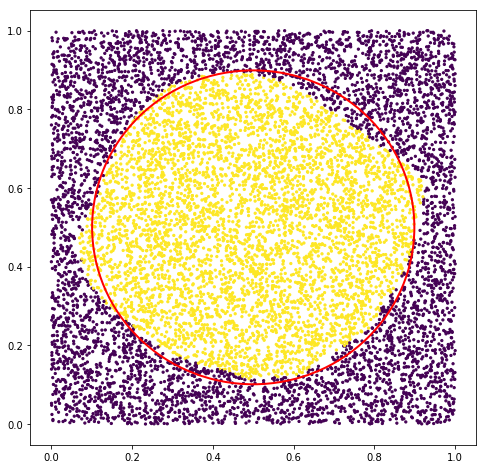

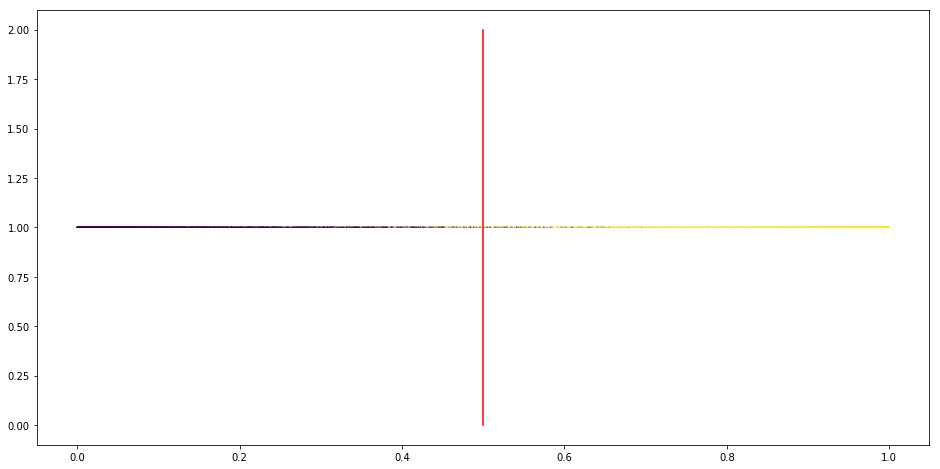

In [8]:
# LossMSE

test_input,test_target=generate_disc_set(10000)
test_input.sub_(mean).div_(std)
output=torch.empty(10000)
decision=torch.empty(10000)
for j in range(test_target.shape[0]):  
    output[j]=net.forward(test_input[j,:])
    decision[j]= int(bool(output[j]>0.5))


fig=plt.figure(figsize=(8, 8))
color=decision
circle1=plt.Circle((0.5,0.5), 1/math.sqrt(2*math.pi),linewidth=2 ,color='r',fill=False)
plt.gcf().gca().add_artist(circle1)
test_input.mul_(std).add_(mean)
plt.scatter(test_input[:,0],test_input[:,1],c=color,s=5)
plt.show()
        
test_input,test_target=generate_disc_set(10000)
test_input.sub_(mean).div_(std)
output=torch.empty(10000)
decision=torch.empty(10000)
for j in range(test_target.shape[0]):  
    output[j]=net.forward(test_input[j,:])

fig=plt.figure(figsize=(16, 8))
color=test_target
plt.scatter(output,torch.ones(10000),c=color,marker='.',s=0.2)
plt.plot([0.5,0.5],[0,2],'r')
plt.show()

# Cross entropy loss

In [40]:
train_input,train_target=generate_disc_set(1000)
test_input,test_target=generate_disc_set(1000)

mean, std = train_input.mean(), train_input.std()
train_input.sub_(mean).div_(std)
test_input.sub_(mean).div_(std)

loss_method=CrossEntroyLoss()
net=Sequential(loss_method,Linear(2,25),Tanh(),Linear(25,2),Sigmoid())
eta=3e-3

for i in range(100):
    acc_loss = 0
    nb_train_errors = 0
    nb_test_errors = 0
    
    for module in net.network:
        module.reset()
    for j in range(train_target.shape[0]):  
        output=net.forward(train_input[j,:])
        nb_train_errors+=int(bool(output.argmax())!=bool(train_target[j]))
        acc_loss += loss_method.loss(output,train_target[j]) 
        net.backward(output,train_target[j])
    for module in net.network:
#         print(module.param())
        module.update(eta)
    
    #test
    for j in range(test_target.shape[0]):  
        output=net.forward(test_input[j,:])
        nb_test_errors+= int(bool(output.argmax())!=bool(test_target[j]))
    print('{:d} acc_train_loss {:.02f} acc_train_error {:.02f}% test_error {:.02f}%'
      .format(i,
              acc_loss,
              (100 * nb_train_errors) / train_input.size(0),
              (100 * nb_test_errors) / test_input.size(0)))

0 acc_train_loss 710.77 acc_train_error 56.70% test_error 47.60%
1 acc_train_loss 675.10 acc_train_error 48.50% test_error 34.30%
2 acc_train_loss 664.52 acc_train_error 35.40% test_error 35.80%
3 acc_train_loss 658.77 acc_train_error 36.30% test_error 36.00%
4 acc_train_loss 652.53 acc_train_error 37.30% test_error 35.20%
5 acc_train_loss 645.49 acc_train_error 36.70% test_error 34.70%
6 acc_train_loss 637.60 acc_train_error 35.70% test_error 32.20%
7 acc_train_loss 629.45 acc_train_error 33.70% test_error 29.50%
8 acc_train_loss 621.27 acc_train_error 31.30% test_error 25.70%
9 acc_train_loss 612.41 acc_train_error 28.20% test_error 21.00%
10 acc_train_loss 602.72 acc_train_error 24.20% test_error 17.90%
11 acc_train_loss 592.97 acc_train_error 19.80% test_error 16.00%
12 acc_train_loss 583.91 acc_train_error 16.70% test_error 14.90%
13 acc_train_loss 575.61 acc_train_error 15.20% test_error 13.40%
14 acc_train_loss 568.10 acc_train_error 13.60% test_error 11.80%
15 acc_train_loss 56

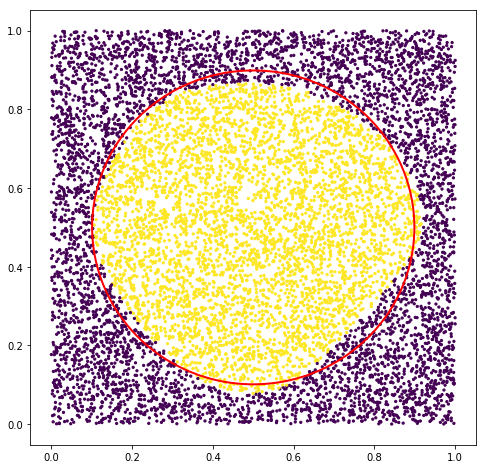

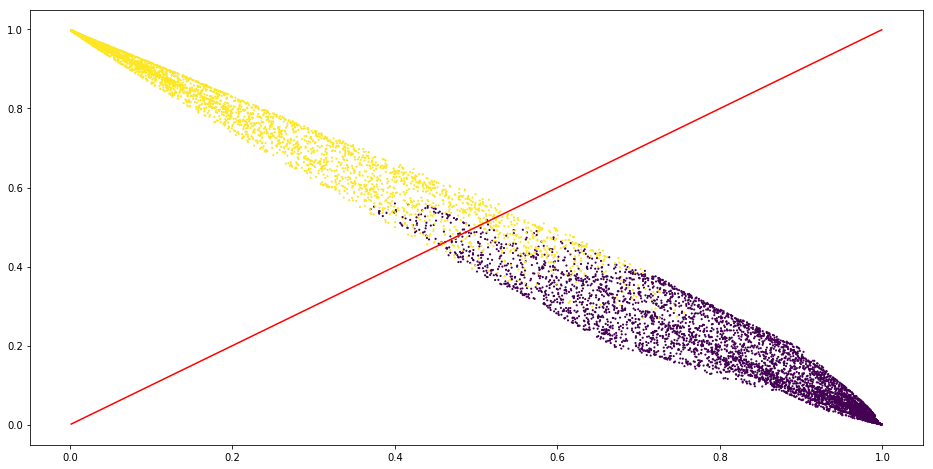

In [42]:
# crossEntropyLoss

test_input,test_target=generate_disc_set(10000)
test_input.sub_(mean).div_(std)
output=torch.empty(10000,2)
decision=torch.empty(10000)
for j in range(test_target.shape[0]):  
    output[j,:]=net.forward(test_input[j,:])
    decision[j]= int(bool(output[j,:].argmax()))


fig=plt.figure(figsize=(8, 8))
color=decision
circle1=plt.Circle((0.5,0.5), 1/math.sqrt(2*math.pi),linewidth=2 ,color='r',fill=False)
plt.gcf().gca().add_artist(circle1)
test_input.mul_(std).add_(mean)
plt.scatter(test_input[:,0],test_input[:,1],c=color,s=5)
plt.show()
        
test_input,test_target=generate_disc_set(10000)
test_input.sub_(mean).div_(std)
output=torch.empty(10000,2)
decision=torch.empty(10000)
for j in range(test_target.shape[0]):  
    output[j,:]=net.forward(test_input[j,:])

fig=plt.figure(figsize=(16, 8))
color=test_target
plt.plot([torch.min(output[:,0]),torch.max(output[:,0])],[torch.min(output[:,0]),torch.max(output[:,0])],c='r')
plt.scatter(output[:,0],output[:,1],c=color,marker='.',s=5)
plt.show()